In [2]:
import matplotlib
import  pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

In [3]:
regexp_stat = re.compile(r'analizo_(.)*_(mean|sum|quantile_max)')
regexp_total = re.compile(r'analizo_total_(.)*')
rep_df_2d = pd.read_csv('data/robo2d-18_09_2018.csv')
rep_df_3d = pd.read_csv('data/3D-analysis-16_09_2018.csv')
#rep_df = pd.concat([rep_df_2d,rep_df_3d],sort=False)
code_df = rep_df_2d[rep_df_2d['is_source']==True]

In [4]:
code_df = code_df.rename(index=str,columns={'new_dir':'folder'})

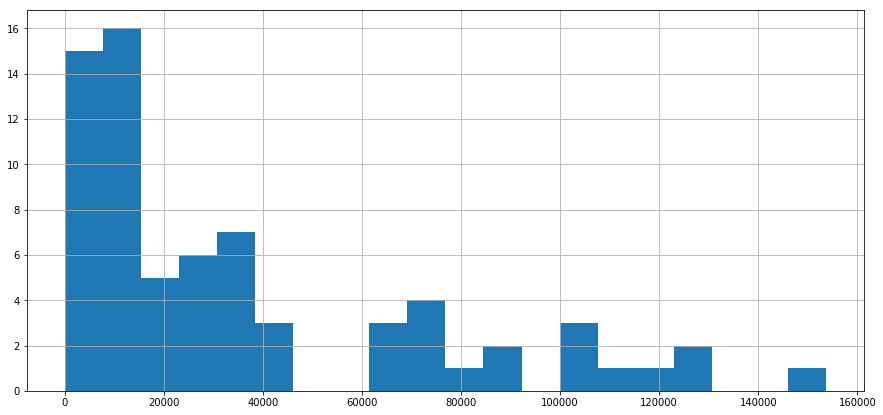

In [5]:
rep_df_2d['analizo_total_loc'].hist(bins=20,figsize=(15,7))

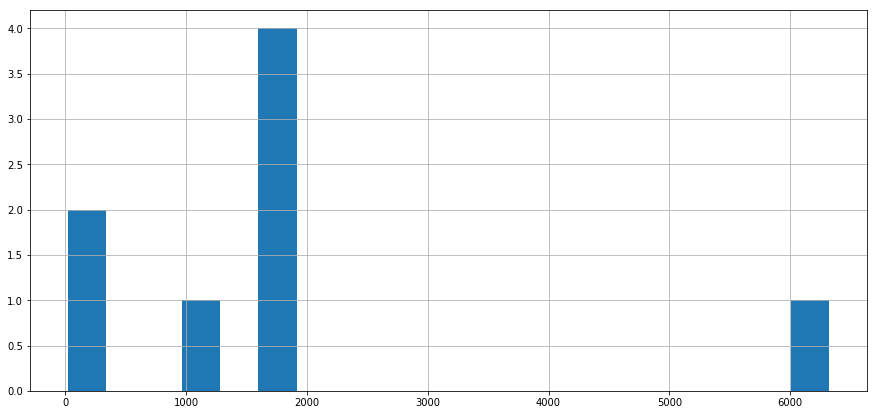

In [6]:
rep_df_3d['analizo_total_loc'].hist(bins=20,figsize=(15,7))

In [7]:
code_df.groupby('year').mean()['analizo_accm_mean']

year
1996    9.988174
1997    4.700791
1998    3.471830
1999    2.715060
2000    1.914417
2001    1.681763
2002    2.406056
2004    2.660519
2007    1.915751
2008    2.152909
2009    4.240528
2011    2.374842
2012    3.036511
2014    1.657464
2015    2.492268
2016    2.633899
Name: analizo_accm_mean, dtype: float64

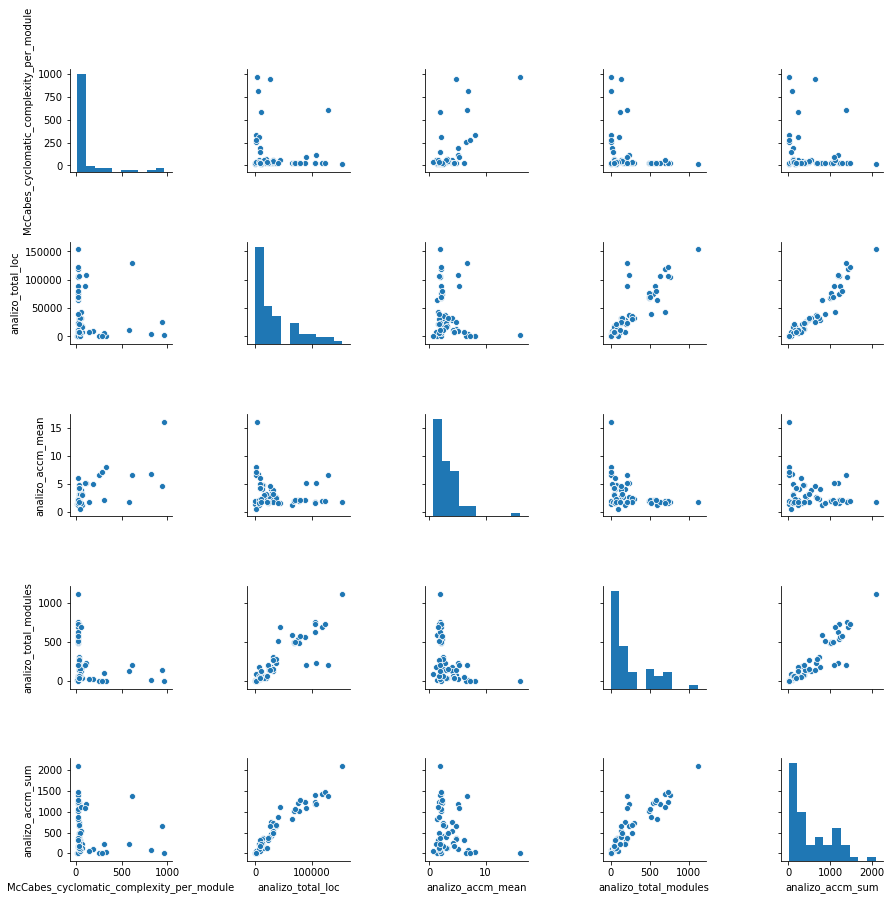

In [8]:
sns.pairplot(code_df[['McCabes_cyclomatic_complexity_per_module','analizo_total_loc','analizo_accm_mean','analizo_total_modules','analizo_accm_sum']].dropna())

In [9]:
code_df_reduced = code_df[[c for c in code_df.columns if regexp_stat.search(c) or regexp_total.search(c) or c == 'folder']].copy()
code_df_reduced['type'] = 'robo'
code_df_reduced['type_original'] = 'robo'

In [10]:
code_df_reduced.dropna(inplace=True)

In [201]:
df1 = pd.read_csv(os.getcwd() +"/data/git-hub-20_09_2018code_analysis__summery_report.csv")

In [202]:
GH_df = df1[[c for c in df1.columns if regexp_stat.search(c) or regexp_total.search(c) or c in ['folder','type']]].copy()
GH_df.rename(columns={'type':'type_original'},inplace=True)
GH_df['type'] = 'others'

In [203]:
GH_df_group_by = GH_df.groupby('type_original').count()

In [204]:
GH_df_group_by_50 = GH_df_group_by[GH_df_group_by.folder>20]

In [205]:
GH_df = GH_df[GH_df['type_original'].isin(GH_df_group_by_50.index.values)]

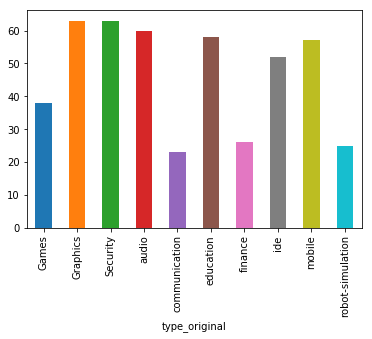

In [206]:
GH_df.groupby('type_original').count()['folder'].plot(kind='bar')

In [207]:
low = .01
high = .97
quant_df = GH_df['analizo_accm_mean'].quantile([low, high])
quant_df

0.01    0.475188
0.97    3.979224
Name: analizo_accm_mean, dtype: float64

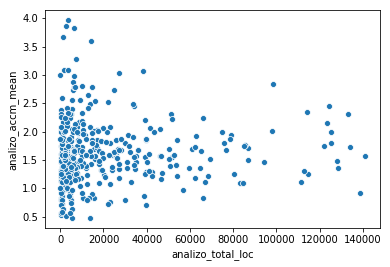

In [208]:
GH_df_reduced =GH_df.loc[(GH_df['analizo_accm_mean']>=quant_df[low]) & (GH_df['analizo_accm_mean']<=quant_df[high]),:]
sns.scatterplot(data=GH_df_reduced[(GH_df_reduced['analizo_total_loc']<150000) & (GH_df_reduced['analizo_total_loc']>-150000)], y='analizo_accm_mean',x='analizo_total_loc')

In [209]:
df_merged= pd.concat([code_df_reduced,GH_df_reduced],sort=False)

In [210]:
df_merged.fillna(0,inplace=True)

In [211]:
df_merged.groupby(['type']).count()

,analizo_acc_mean,analizo_acc_quantile_max,analizo_acc_sum,analizo_accm_mean,analizo_accm_quantile_max,analizo_accm_sum,analizo_amloc_mean,analizo_amloc_quantile_max,analizo_amloc_sum,analizo_anpm_mean,...,analizo_total_cof,analizo_total_eloc,analizo_total_loc,analizo_total_methods_per_abstract_class,analizo_total_modules,analizo_total_modules_with_defined_attributes,analizo_total_modules_with_defined_methods,analizo_total_nom,folder,type_original
type,,,,,,,,,,,,,,,,,,,,,
others,440,440,440,440,440,440,440,440,440,440,...,440,440,440,440,440,440,440,440,440,440
robo,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70


In [212]:
float(38)/(198+38)*100

16.101694915254235

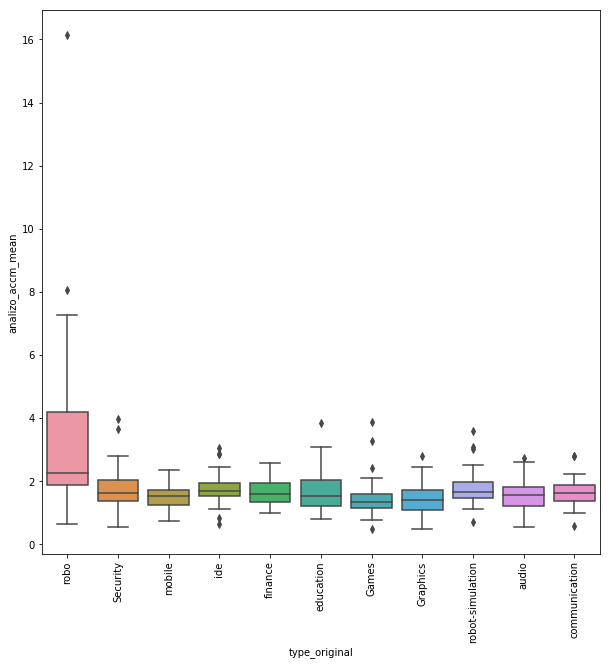

In [237]:
fix,ax = plt.subplots(figsize=(10,10))
g = sns.boxplot(x='type_original',y='analizo_accm_mean',data=df_merged)
#g = sns.swarmplot(x='type_original',y='analizo_accm_mean',data=df_merged,color='black')
for item in g.get_xticklabels():
     item.set_rotation(90)

In [214]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [215]:
X = df_merged.select_dtypes(include=[np.number])
Y = df_merged.loc[:,'type']

In [216]:
# feature extraction
model = RandomForestClassifier()

In [217]:
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
X.columns[fit.support_]

Index([u'analizo_accm_mean', u'analizo_amloc_mean', u'analizo_cbo_mean',
       u'analizo_loc_mean'],
      dtype='object')

In [218]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
fitl= model.fit(X,Y)
model.score(X_test,Y_test)
X.columns[np.flip(np.argsort(model.feature_importances_),0)]

Index([u'analizo_loc_mean', u'analizo_accm_mean', u'analizo_mmloc_mean',
       u'analizo_acc_mean', u'analizo_npm_quantile_max', u'analizo_anpm_mean',
       u'analizo_amloc_mean', u'analizo_nom_quantile_max',
       u'analizo_total_cof', u'analizo_loc_quantile_max', u'analizo_noa_sum',
       u'analizo_npa_quantile_max', u'analizo_sc_mean',
       u'analizo_dit_quantile_max', u'analizo_noa_mean',
       u'analizo_lcom4_quantile_max', u'analizo_total_loc',
       u'analizo_sc_quantile_max', u'analizo_lcom4_mean',
       u'analizo_noa_quantile_max',
       u'analizo_total_methods_per_abstract_class', u'analizo_lcom4_sum',
       u'analizo_cbo_sum', u'analizo_rfc_mean', u'analizo_loc_sum',
       u'analizo_noc_mean', u'analizo_mmloc_quantile_max',
       u'analizo_accm_quantile_max', u'analizo_dit_mean', u'analizo_rfc_sum',
       u'analizo_total_modules', u'analizo_cbo_quantile_max',
       u'analizo_rfc_quantile_max', u'analizo_cbo_mean', u'analizo_mmloc_sum',
       u'analizo_anpm_qu

In [219]:
pred = model.predict(X) 

In [220]:
def set_wrong_type(pred,Y,df,type_class):
    df.loc[:,'wrong'] = False
    df.loc[(pred != Y),'wrong'] = True
    df.loc[(pred != Y) & (df['type'] == type_class),'type_wrong'] = 'wrong_' +type_class    
    df.loc[(pred == Y) & (df['type'] == type_class),'type_wrong'] = type_class
    df.loc[(pred != Y) & (df['type'] == 'others'),'type_wrong'] = 'wrong_others'
    df.loc[(pred == Y) & (df['type'] == 'others'),'type_wrong'] = 'others'
    return df
df_merged = set_wrong_type(pred,Y,df_merged,'robo')

In [221]:
df_merged_acc = df_merged.groupby('type_wrong').count()['analizo_acc_mean']
df_merged_acc

type_wrong
others        440
robo           68
wrong_robo      2
Name: analizo_acc_mean, dtype: int64

# Accurercy : 

In [222]:
import collections
pred_robo_cont = collections.Counter(pred)['robo']
Y_robo_cont = collections.Counter(Y)['robo']

In [223]:
prec = float(df_merged_acc.loc['robo']) / pred_robo_cont
recall = float(df_merged_acc.loc['robo']) / Y_robo_cont
'prec : '  , prec , 'recall :'  , recall , 'f1 :' , (2*(prec*recall)/(prec+recall))

('prec : ', 1.0, 'recall :', 0.9714285714285714, 'f1 :', 0.9855072463768115)

pd.set_option('max_colwidth', 800)

df_merged[df_merged['wrong']==True][['analizo_accm_mean','analizo_dit_mean','type_wrong','type','folder']]

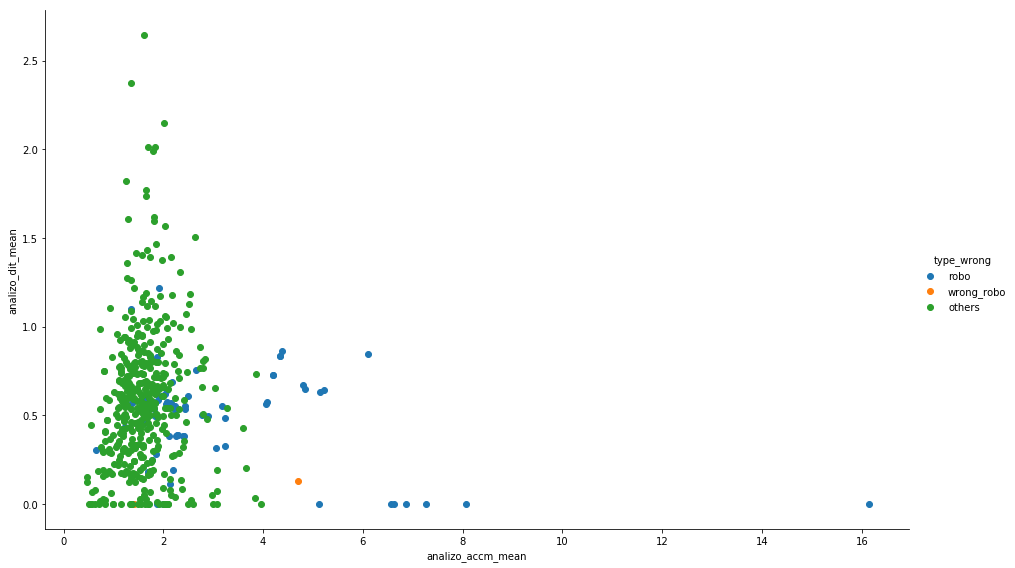

In [224]:
fg = sns.FacetGrid(data=df_merged, hue='type_wrong',  aspect=1.61,height=8)
fg.map(plt.scatter, 'analizo_accm_mean','analizo_dit_mean',).add_legend()

In [225]:
import pickle

In [226]:
pickle.dump(model,open('dump','w'))

In [227]:
type_class =  'robot-simulation'
GH_df_reduced.loc[GH_df_reduced['type_original']==type_class,'type' ] = type_class

In [228]:
GH_df_reduced.groupby('type').count()

,analizo_npa_quantile_max,analizo_mmloc_sum,folder,analizo_lcom4_quantile_max,analizo_rfc_sum,analizo_dit_sum,analizo_dit_mean,analizo_nom_sum,analizo_noc_mean,analizo_cbo_mean,...,analizo_noc_sum,analizo_sc_quantile_max,analizo_amloc_mean,analizo_acc_mean,analizo_amloc_sum,analizo_total_loc,analizo_cbo_quantile_max,analizo_total_nom,analizo_rfc_mean,analizo_total_eloc
type,,,,,,,,,,,,,,,,,,,,,
others,416,416,416,416,416,416,416,416,416,416,...,416,416,416,416,416,416,416,416,416,416
robot-simulation,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24


In [229]:
X = GH_df_reduced.select_dtypes(include=[np.number])

In [230]:
Y = GH_df_reduced.loc[:,'type']
# feature extraction
model = RandomForestClassifier()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
fitl= model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9204545454545454

In [231]:
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_
X.columns[fit.support_]

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False  True False False False  True False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
Feature Ranking: [34 33 37  4 49  7 42  5 26 11 36 20 18 39 46 22 55  1 32 24 48  1 51 29
  1 13  6 47 53 25 31 19  9 52 10 27 40  3 15 28 54 44 43 23 45 41  2 30
 21 12 17 38 35 50 16 14  8]


Index([u'analizo_noa_mean', u'analizo_anpm_mean', u'analizo_mmloc_mean'], dtype='object')

In [232]:
pred = model.predict(X)

In [233]:
GH_df_reduced_type = set_wrong_type(pred,Y,GH_df_reduced,'Security')
GH_df_reduced_type_acc = GH_df_reduced_type.groupby('type_wrong').count()['analizo_npa_quantile_max']
GH_df_reduced_type_acc

type_wrong
others    416
Name: analizo_npa_quantile_max, dtype: int64

In [234]:
prec = float(GH_df_reduced_type_acc.loc['Security']) / (GH_df_reduced_type_acc.loc['wrong_others'] + GH_df_reduced_type_acc.loc['Security'])
recall = float(GH_df_reduced_type_acc.loc['Security']) / (GH_df_reduced_type_acc.loc['wrong_Security'] + GH_df_reduced_type_acc.loc['Security'])
'prec : '  , prec , 'recall :'  , recall , 'f1 :' , (2*(prec*recall)/(prec+recall))

KeyError: u'the label [Security] is not in the [index]'

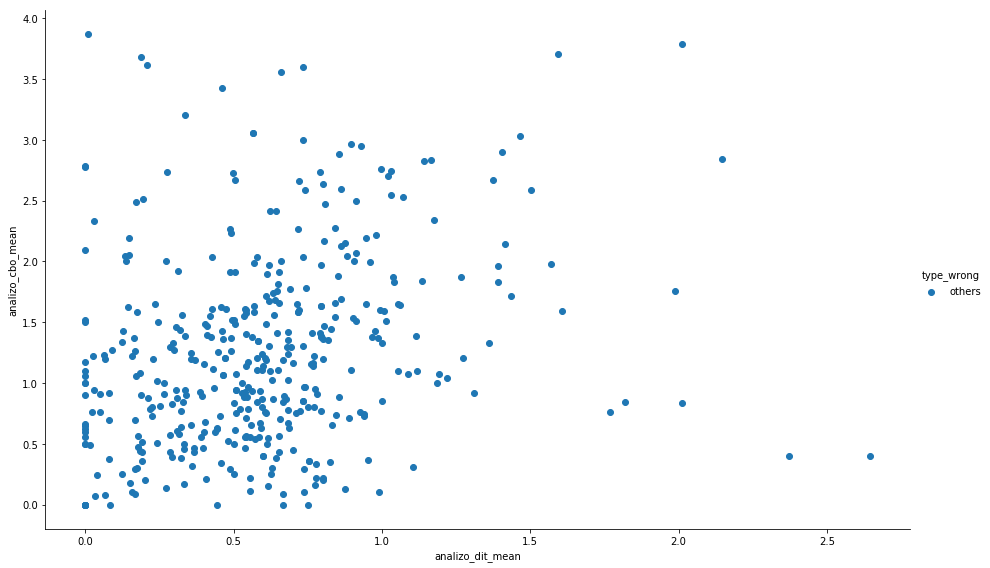

In [235]:
fg = sns.FacetGrid(data=GH_df_reduced_type, hue='type_wrong',  aspect=1.61,height=8)
fg.map(plt.scatter, 'analizo_dit_mean','analizo_cbo_mean',).add_legend()